In [22]:
from helper import *
from stats import *
from imp import reload   
import helper
import stats
reload(helper)
reload(stats)
get_signal_performance_result

<function helper.get_signal_performance_result(all_period_signal, signal_dire, period, product_list, train_sample, test_sample)>

In [23]:
## parallel generate the distribution of a signal
def par_get_all_signal(signal_name, file_list, product, period, HEAD_PATH="d:/intern", SAVE_PATH="e:/intern", DATA_PATH="d:/intern"):
    n_files = len(file_list)
    all_signal = np.array([])
    for file in file_list:
        S = load(HEAD_PATH+"/tmp pkl/"+product+"/"+signal_name+"/"+file) ## signal
        good = load(DATA_PATH+"/good pkl/"+product+"/"+file) ## good singal
        signal = S[good]
        moving_average(signal,period)
        chosen = (np.arange(len(signal))+1) % period==0
        all_signal = np.concatenate((all_signal, signal[chosen]), axis=0)
    save(all_signal, SAVE_PATH+"/all signal/"+product+"."+signal_name+".pkl")

- number of cores, set this number according to your computer

In [3]:
CORE_NUM = int(os.environ['NUMBER_OF_PROCESSORS'])
CORE_NUM

16

- sample product, you can change to your specific product symbol

In [4]:
product_list = ["IF", "IH", "IC", "T", "TF"]

In [5]:
import dask
from dask import compute, delayed

- sample period

In [6]:
period = 4096

In [7]:
all_dates = os.listdir(DATA_PATH + product_list[0])
all_dates.sort()
all_dates = np.array(all_dates)
n_days = len(all_dates)
n_days


1092

- choose an example day

In [8]:
train_sample = all_dates<"2018"
test_sample = all_dates>"2018"
date_str = [n[0:8] for n in all_dates]
format_dates = np.array([pd.to_datetime(d) for d in date_str])


- Now we start our new topics:
- cross-period signal
- cross-symbol signal
- arbitrage

- First, we look at cross-period signal

In [10]:
file = all_dates[10]
product = "IF"
SAVE_PATH = "e:/intern"
signal_func = "trade.imb"
period_list =  np.power(2, range(10,13))
data = load(HEAD_PATH+"/pkl tick/"+product+"/"+file)

- we can first generate good index of data
- because loading data each time is too time consuming

In [11]:
import os
os.makedirs(HEAD_PATH + "/good pkl", exist_ok=True)
for product in product_list:
    os.makedirs(HEAD_PATH + "/good pkl/" + product, exist_ok=True)

In [1]:
## calculate linear combination of signals using parameter weight
def get_comb_signal(date, signal_func, product, period_list, HEAD_PATH, weight):
    comb_signal = [] ## initial signal is empty
    #good = load(HEAD_PATH+"/good pkl/"+product+"/"+date)
    n_period = len(period_list) ## number of period
    for i in range(n_period):
        signal_name = signal_func+"."+str(period_list[i])
        S = load(HEAD_PATH+"/tmp pkl/"+product+"/"+signal_name+"/"+date)
        #S = S/np.std(S[good])/n_period
        S = S*weight[i]
        if len(comb_signal)==0: # if it's the first signal, just give it to comb_signal
            comb_signal=S
        else: 
            comb_signal += S ## otherwise, add the weighed value to comb_signal
    save(comb_signal, HEAD_PATH+"/tmp pkl/"+product+"/"+signal_func+".comb/"+date) ## save the final result
    

In [13]:
os.makedirs(HEAD_PATH+"/all signal", exist_ok=True)
dire_signal_list = ["trade.imb", "total.trade.imb", "nr", "dbook", "range.pos", "price.osci", "ma.dif.10", "kdj.k", "kdj.j"]
range_signal_list = ["", "range", "std", "volume.open.ratio", "trend.index"]
all_signal_list = np.array([])
for range_signal in range_signal_list:
    for dire_signal in dire_signal_list:
        if len(range_signal)==0:
            signal_name = dire_signal
        else:
            signal_name = dire_signal+"."+range_signal
        all_signal_list = np.append(all_signal_list,signal_name)
len(all_signal_list)
all_comb_list = [signal+".comb" for signal in all_signal_list]
all_period_signal = [signal+".4096" for signal in all_signal_list]
weight = (1/np.sqrt(period_list))/(sum(1/np.sqrt(period_list)))

In [17]:
for product in product_list:
    for signal_func in all_signal_list:
        os.makedirs(SAVE_PATH+"/tmp pkl/"+product+"/"+signal_func+".comb", exist_ok=True)

In [18]:
%%time
for product in product_list:
    for signal_func in all_signal_list:
        print(product,signal_func)
        parLapply(CORE_NUM, all_dates, get_comb_signal,signal_func=signal_func,  
                  product=product, period_list=period_list,HEAD_PATH=SAVE_PATH, weight=weight)
        
##Wall time: 3h 23min 39s

IF trade.imb
IF total.trade.imb
IF nr
IF dbook
IF range.pos
IF price.osci
IF ma.dif.10
IF kdj.k
IF kdj.j
IF trade.imb.range
IF total.trade.imb.range
IF nr.range
IF dbook.range
IF range.pos.range
IF price.osci.range
IF ma.dif.10.range
IF kdj.k.range
IF kdj.j.range
IF trade.imb.std
IF total.trade.imb.std
IF nr.std
IF dbook.std
IF range.pos.std
IF price.osci.std
IF ma.dif.10.std
IF kdj.k.std
IF kdj.j.std
IF trade.imb.volume.open.ratio
IF total.trade.imb.volume.open.ratio
IF nr.volume.open.ratio
IF dbook.volume.open.ratio
IF range.pos.volume.open.ratio
IF price.osci.volume.open.ratio
IF ma.dif.10.volume.open.ratio
IF kdj.k.volume.open.ratio
IF kdj.j.volume.open.ratio
IF trade.imb.trend.index
IF total.trade.imb.trend.index
IF nr.trend.index
IF dbook.trend.index
IF range.pos.trend.index
IF price.osci.trend.index
IF ma.dif.10.trend.index
IF kdj.k.trend.index
IF kdj.j.trend.index
IH trade.imb
IH total.trade.imb
IH nr
IH dbook
IH range.pos
IH price.osci
IH ma.dif.10
IH kdj.k
IH kdj.j
IH trade.i

In [25]:
%%time
SAVE_PATH = "e:/intern"
for product in product_list:
    print(product)
    parLapply(CORE_NUM, all_comb_list, par_get_all_signal, file_list=all_dates, product=product, period=4096, HEAD_PATH=SAVE_PATH,
             SAVE_PATH = SAVE_PATH, DATA_PATH=SAVE_PATH);

# IF
# IH
# IC
# T
# TF
# Wall time: 1h 33min 15s

IF
IH
IC
T
TF
Wall time: 1h 33min 15s


In [26]:
%%time
SIGNAL_PATH = "e:/intern"
for product in product_list:
    spread = product_info[product]["spread"]
    tranct = product_info[product]["tranct"]
    tranct_ratio = product_info[product]["tranct.ratio"]
    if product=="IF" or product=="IH" or product=="IC":
        atr_filter = 100
        avg_pnl = 10
    else:
        atr_filter = 20
        avg_pnl = 2
    for signal in all_signal_list:
        print(product, signal)
        evaluate_signal(signal, all_dates, product, avg_pnl, 20, CORE_NUM, HEAD_PATH, SIGNAL_PATH,
                period="comb", split_str="2018", tranct=tranct, 
                max_spread=spread*1.1, tranct_ratio=tranct_ratio, atr_filter=atr_filter, save_path="signal result atr")
#Wall time: 12h 18min 25s



IF trade.imb
reverse=1
reverse=-1
IF total.trade.imb
reverse=1
reverse=-1
IF nr
reverse=1
reverse=-1
IF dbook
reverse=1
reverse=-1
IF range.pos
reverse=1
reverse=-1
IF price.osci
reverse=1


d:\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


reverse=-1
IF ma.dif.10
reverse=1
reverse=-1
IF kdj.k
reverse=1
reverse=-1
IF kdj.j
reverse=1
reverse=-1
IF trade.imb.range


d:\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


reverse=1
reverse=-1
IF total.trade.imb.range
reverse=1


d:\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


reverse=-1
IF nr.range
reverse=1


d:\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


reverse=-1
IF dbook.range
reverse=1


d:\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


reverse=-1
IF range.pos.range
reverse=1


d:\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


reverse=-1
IF price.osci.range
reverse=1


d:\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


reverse=-1
IF ma.dif.10.range
reverse=1


d:\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


reverse=-1
IF kdj.k.range
reverse=1


d:\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


reverse=-1
IF kdj.j.range
reverse=1


d:\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


reverse=-1
IF trade.imb.std
reverse=1
reverse=-1
IF total.trade.imb.std
reverse=1
reverse=-1
IF nr.std
reverse=1
reverse=-1
IF dbook.std
reverse=1
reverse=-1
IF range.pos.std
reverse=1
reverse=-1
IF price.osci.std


d:\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


reverse=1
reverse=-1
IF ma.dif.10.std
reverse=1
reverse=-1
IF kdj.k.std
reverse=1
reverse=-1
IF kdj.j.std
reverse=1
reverse=-1
IF trade.imb.volume.open.ratio
reverse=1
reverse=-1
IF total.trade.imb.volume.open.ratio
reverse=1
reverse=-1
IF nr.volume.open.ratio
reverse=1
reverse=-1
IF dbook.volume.open.ratio
reverse=1
reverse=-1
IF range.pos.volume.open.ratio
reverse=1
reverse=-1
IF price.osci.volume.open.ratio
reverse=1


d:\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


reverse=-1
IF ma.dif.10.volume.open.ratio
reverse=1
reverse=-1
IF kdj.k.volume.open.ratio
reverse=1
reverse=-1
IF kdj.j.volume.open.ratio
reverse=1
reverse=-1
IF trade.imb.trend.index


d:\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


reverse=1
reverse=-1
IF total.trade.imb.trend.index
reverse=1


d:\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


reverse=-1
IF nr.trend.index
reverse=1


d:\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


reverse=-1
IF dbook.trend.index
reverse=1


d:\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


reverse=-1
IF range.pos.trend.index
reverse=1


d:\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


reverse=-1
IF price.osci.trend.index
reverse=1


d:\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


reverse=-1
IF ma.dif.10.trend.index
reverse=1


d:\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


reverse=-1
IF kdj.k.trend.index
reverse=1


d:\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


reverse=-1
IF kdj.j.trend.index
reverse=1


d:\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


reverse=-1
IH trade.imb
reverse=1
reverse=-1
IH total.trade.imb
reverse=1
reverse=-1
IH nr
reverse=1
reverse=-1
IH dbook
reverse=1
reverse=-1
IH range.pos
reverse=1
reverse=-1
IH price.osci
reverse=1


d:\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


reverse=-1
IH ma.dif.10
reverse=1
reverse=-1
IH kdj.k
reverse=1
reverse=-1
IH kdj.j
reverse=1
reverse=-1
IH trade.imb.range
reverse=1


d:\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


reverse=-1
IH total.trade.imb.range
reverse=1


d:\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


reverse=-1
IH nr.range
reverse=1


d:\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


reverse=-1
IH dbook.range
reverse=1


d:\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


reverse=-1
IH range.pos.range
reverse=1


d:\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


reverse=-1
IH price.osci.range
reverse=1


d:\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


reverse=-1
IH ma.dif.10.range
reverse=1


d:\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


reverse=-1
IH kdj.k.range
reverse=1


d:\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


reverse=-1
IH kdj.j.range
reverse=1


d:\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


reverse=-1
IH trade.imb.std
reverse=1
reverse=-1
IH total.trade.imb.std
reverse=1
reverse=-1
IH nr.std
reverse=1
reverse=-1
IH dbook.std
reverse=1
reverse=-1
IH range.pos.std
reverse=1
reverse=-1
IH price.osci.std


d:\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


reverse=1
reverse=-1
IH ma.dif.10.std
reverse=1
reverse=-1
IH kdj.k.std
reverse=1
reverse=-1
IH kdj.j.std
reverse=1
reverse=-1
IH trade.imb.volume.open.ratio
reverse=1
reverse=-1
IH total.trade.imb.volume.open.ratio
reverse=1
reverse=-1
IH nr.volume.open.ratio
reverse=1
reverse=-1
IH dbook.volume.open.ratio
reverse=1
reverse=-1
IH range.pos.volume.open.ratio
reverse=1
reverse=-1
IH price.osci.volume.open.ratio
reverse=1


d:\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


reverse=-1
IH ma.dif.10.volume.open.ratio
reverse=1
reverse=-1
IH kdj.k.volume.open.ratio
reverse=1
reverse=-1
IH kdj.j.volume.open.ratio
reverse=1
reverse=-1
IH trade.imb.trend.index
reverse=1


d:\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


reverse=-1
IH total.trade.imb.trend.index
reverse=1


d:\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


reverse=-1
IH nr.trend.index
reverse=1


d:\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


reverse=-1
IH dbook.trend.index
reverse=1


d:\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


reverse=-1
IH range.pos.trend.index
reverse=1


d:\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


reverse=-1
IH price.osci.trend.index
reverse=1


d:\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


reverse=-1
IH ma.dif.10.trend.index
reverse=1


d:\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


reverse=-1
IH kdj.k.trend.index
reverse=1


d:\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


reverse=-1
IH kdj.j.trend.index
reverse=1


d:\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


reverse=-1
IC trade.imb
reverse=1
reverse=-1
IC total.trade.imb
reverse=1
reverse=-1
IC nr
reverse=1
reverse=-1
IC dbook
reverse=1
reverse=-1
IC range.pos
reverse=1
reverse=-1
IC price.osci
reverse=1


d:\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


reverse=-1
IC ma.dif.10
reverse=1
reverse=-1
IC kdj.k
reverse=1
reverse=-1
IC kdj.j
reverse=1
reverse=-1
IC trade.imb.range


d:\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


reverse=1
reverse=-1
IC total.trade.imb.range
reverse=1


d:\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


reverse=-1
IC nr.range
reverse=1


d:\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


reverse=-1
IC dbook.range
reverse=1


d:\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


reverse=-1
IC range.pos.range
reverse=1


d:\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


reverse=-1
IC price.osci.range
reverse=1


d:\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


reverse=-1
IC ma.dif.10.range
reverse=1


d:\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


reverse=-1
IC kdj.k.range
reverse=1


d:\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


reverse=-1
IC kdj.j.range
reverse=1


d:\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


reverse=-1
IC trade.imb.std
reverse=1


d:\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


reverse=-1
IC total.trade.imb.std
reverse=1


d:\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


reverse=-1
IC nr.std
reverse=1


d:\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


reverse=-1
IC dbook.std
reverse=1


d:\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


reverse=-1
IC range.pos.std
reverse=1


d:\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


reverse=-1
IC price.osci.std
reverse=1


d:\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


reverse=-1
IC ma.dif.10.std
reverse=1


d:\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


reverse=-1
IC kdj.k.std
reverse=1


d:\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


reverse=-1
IC kdj.j.std
reverse=1


d:\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


reverse=-1
IC trade.imb.volume.open.ratio
reverse=1
reverse=-1
IC total.trade.imb.volume.open.ratio
reverse=1
reverse=-1
IC nr.volume.open.ratio
reverse=1
reverse=-1
IC dbook.volume.open.ratio
reverse=1
reverse=-1
IC range.pos.volume.open.ratio
reverse=1
reverse=-1
IC price.osci.volume.open.ratio
reverse=1


d:\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


reverse=-1
IC ma.dif.10.volume.open.ratio
reverse=1
reverse=-1
IC kdj.k.volume.open.ratio
reverse=1
reverse=-1
IC kdj.j.volume.open.ratio
reverse=1
reverse=-1
IC trade.imb.trend.index
reverse=1


d:\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


reverse=-1
IC total.trade.imb.trend.index
reverse=1


d:\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


reverse=-1
IC nr.trend.index
reverse=1


d:\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


reverse=-1
IC dbook.trend.index
reverse=1


d:\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


reverse=-1
IC range.pos.trend.index
reverse=1


d:\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


reverse=-1
IC price.osci.trend.index
reverse=1


d:\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


reverse=-1
IC ma.dif.10.trend.index
reverse=1


d:\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


reverse=-1
IC kdj.k.trend.index
reverse=1


d:\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


reverse=-1
IC kdj.j.trend.index
reverse=1


d:\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


reverse=-1
T trade.imb
reverse=1
reverse=-1
T total.trade.imb
reverse=1
reverse=-1
T nr
reverse=1
reverse=-1
T dbook
reverse=1
reverse=-1
T range.pos
reverse=1
reverse=-1
T price.osci
reverse=1


d:\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


reverse=-1
T ma.dif.10
reverse=1
reverse=-1
T kdj.k
reverse=1
reverse=-1
T kdj.j
reverse=1
reverse=-1
T trade.imb.range


d:\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


reverse=1
reverse=-1
T total.trade.imb.range
reverse=1


d:\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


reverse=-1
T nr.range
reverse=1


d:\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


reverse=-1
T dbook.range
reverse=1


d:\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


reverse=-1
T range.pos.range
reverse=1


d:\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


reverse=-1
T price.osci.range
reverse=1


d:\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


reverse=-1
T ma.dif.10.range
reverse=1


d:\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


reverse=-1
T kdj.k.range
reverse=1


d:\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


reverse=-1
T kdj.j.range
reverse=1


d:\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


reverse=-1
T trade.imb.std
reverse=1
reverse=-1
T total.trade.imb.std
reverse=1
reverse=-1
T nr.std
reverse=1
reverse=-1
T dbook.std
reverse=1
reverse=-1
T range.pos.std
reverse=1
reverse=-1
T price.osci.std
reverse=1


d:\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


reverse=-1
T ma.dif.10.std
reverse=1
reverse=-1
T kdj.k.std
reverse=1
reverse=-1
T kdj.j.std
reverse=1
reverse=-1
T trade.imb.volume.open.ratio
reverse=1
reverse=-1
T total.trade.imb.volume.open.ratio
reverse=1
reverse=-1
T nr.volume.open.ratio
reverse=1
reverse=-1
T dbook.volume.open.ratio
reverse=1
reverse=-1
T range.pos.volume.open.ratio
reverse=1
reverse=-1
T price.osci.volume.open.ratio
reverse=1


d:\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


reverse=-1
T ma.dif.10.volume.open.ratio
reverse=1
reverse=-1
T kdj.k.volume.open.ratio
reverse=1
reverse=-1
T kdj.j.volume.open.ratio
reverse=1
reverse=-1
T trade.imb.trend.index
reverse=1


d:\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


reverse=-1
T total.trade.imb.trend.index
reverse=1


d:\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


reverse=-1
T nr.trend.index
reverse=1


d:\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


reverse=-1
T dbook.trend.index
reverse=1


d:\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


reverse=-1
T range.pos.trend.index
reverse=1


d:\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


reverse=-1
T price.osci.trend.index
reverse=1


d:\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


reverse=-1
T ma.dif.10.trend.index
reverse=1


d:\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


reverse=-1
T kdj.k.trend.index
reverse=1


d:\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


reverse=-1
T kdj.j.trend.index
reverse=1


d:\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


reverse=-1
TF trade.imb
reverse=1
reverse=-1
TF total.trade.imb
reverse=1
reverse=-1
TF nr
reverse=1
reverse=-1
TF dbook
reverse=1
reverse=-1
TF range.pos
reverse=1
reverse=-1
TF price.osci
reverse=1


d:\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


reverse=-1
TF ma.dif.10
reverse=1
reverse=-1
TF kdj.k
reverse=1
reverse=-1
TF kdj.j
reverse=1
reverse=-1
TF trade.imb.range
reverse=1


d:\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


reverse=-1
TF total.trade.imb.range
reverse=1


d:\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


reverse=-1
TF nr.range
reverse=1


d:\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


reverse=-1
TF dbook.range
reverse=1


d:\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


reverse=-1
TF range.pos.range
reverse=1


d:\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


reverse=-1
TF price.osci.range
reverse=1


d:\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


reverse=-1
TF ma.dif.10.range
reverse=1


d:\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


reverse=-1
TF kdj.k.range
reverse=1


d:\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


reverse=-1
TF kdj.j.range
reverse=1


d:\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


reverse=-1
TF trade.imb.std
reverse=1
reverse=-1
TF total.trade.imb.std
reverse=1
reverse=-1
TF nr.std
reverse=1
reverse=-1
TF dbook.std
reverse=1
reverse=-1
TF range.pos.std
reverse=1
reverse=-1
TF price.osci.std
reverse=1


d:\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


reverse=-1
TF ma.dif.10.std
reverse=1
reverse=-1
TF kdj.k.std
reverse=1
reverse=-1
TF kdj.j.std
reverse=1
reverse=-1
TF trade.imb.volume.open.ratio
reverse=1
reverse=-1
TF total.trade.imb.volume.open.ratio
reverse=1
reverse=-1
TF nr.volume.open.ratio
reverse=1
reverse=-1
TF dbook.volume.open.ratio
reverse=1
reverse=-1
TF range.pos.volume.open.ratio
reverse=1
reverse=-1
TF price.osci.volume.open.ratio
reverse=1


d:\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


reverse=-1
TF ma.dif.10.volume.open.ratio
reverse=1
reverse=-1
TF kdj.k.volume.open.ratio
reverse=1
reverse=-1
TF kdj.j.volume.open.ratio
reverse=1
reverse=-1
TF trade.imb.trend.index
reverse=1


d:\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


reverse=-1
TF total.trade.imb.trend.index
reverse=1


d:\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


reverse=-1
TF nr.trend.index
reverse=1


d:\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


reverse=-1
TF dbook.trend.index
reverse=1


d:\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


reverse=-1
TF range.pos.trend.index
reverse=1


d:\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


reverse=-1
TF price.osci.trend.index
reverse=1


d:\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


reverse=-1
TF ma.dif.10.trend.index
reverse=1


d:\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


reverse=-1
TF kdj.k.trend.index
reverse=1


d:\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


reverse=-1
TF kdj.j.trend.index
reverse=1


d:\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


reverse=-1
Wall time: 12h 18min 25s


- now we compare the result of comb signal and previous signal

In [27]:
result_atr = get_signal_performance_result(all_period_signal, "signal result atr", "4096", product_list, train_sample, test_sample)
result_comb= get_signal_performance_result(all_comb_list, "signal result atr", "comb", product_list, train_sample, test_sample)

In [29]:
min_num=0
good_trend = (result_atr["trend.signal.stat"]["num"]>min_num) & (result_atr["trend.signal.stat"]["trainSharpe"]>0.5) & (result_atr["trend.signal.stat"]["testSharpe"]>0.5)
good_reverse = (result_atr["reverse.signal.stat"]["num"]>min_num) & (result_atr["reverse.signal.stat"]["trainSharpe"]>0.5) & (result_atr["reverse.signal.stat"]["testSharpe"]>0.5)
print("4096 signals: "+ str(sum(good_trend | good_reverse)))
train_sharpe = np.mean(np.append(result_atr["trend.signal.stat"]["trainSharpe"][good_trend],
                  result_atr["reverse.signal.stat"]["trainSharpe"][good_reverse]))
test_sharpe = np.mean(np.append(result_atr["trend.signal.stat"]["testSharpe"][good_trend],
                  result_atr["reverse.signal.stat"]["testSharpe"][good_reverse]))
print("train sharpe: ", train_sharpe)
print("test sharpe: ", test_sharpe)
good_trend = (result_comb["trend.signal.stat"]["num"]>min_num) & (result_comb["trend.signal.stat"]["trainSharpe"]>0.5) & (result_comb["trend.signal.stat"]["testSharpe"]>0.5)
good_reverse = (result_comb["reverse.signal.stat"]["num"]>min_num) & (result_comb["reverse.signal.stat"]["trainSharpe"]>0.5) & (result_comb["reverse.signal.stat"]["testSharpe"]>0.5)
print("comb signals: "+ str(sum(good_trend | good_reverse)))
train_sharpe = np.mean(np.append(result_comb["trend.signal.stat"]["trainSharpe"][good_trend],
                  result_comb["reverse.signal.stat"]["trainSharpe"][good_reverse]))
test_sharpe = np.mean(np.append(result_comb["trend.signal.stat"]["testSharpe"][good_trend],
                  result_comb["reverse.signal.stat"]["testSharpe"][good_reverse]))
print("train sharpe: ", train_sharpe)
print("test sharpe: ", test_sharpe)

# 4096 signals: 9
# train sharpe:  0.881048735863792
# test sharpe:  0.7237253273942355
# comb signals: 4
# train sharpe:  0.716140364741529
# test sharpe:  0.7436314661985906




4096 signals: 9
train sharpe:  0.881048735863792
test sharpe:  0.7237253273942355
comb signals: 4
train sharpe:  0.716140364741529
test sharpe:  0.7436314661985906


In [31]:
min_num=1
good_trend = (result_atr["trend.signal.stat"]["num"]>min_num) & (result_atr["trend.signal.stat"]["trainSharpe"]>0.5) & (result_atr["trend.signal.stat"]["testSharpe"]>0.5)
good_reverse = (result_atr["reverse.signal.stat"]["num"]>min_num) & (result_atr["reverse.signal.stat"]["trainSharpe"]>0.5) & (result_atr["reverse.signal.stat"]["testSharpe"]>0.5)
print("4096 signals: "+ str(sum(good_trend | good_reverse)))
train_sharpe = np.mean(np.append(result_atr["trend.signal.stat"]["trainSharpe"][good_trend],
                  result_atr["reverse.signal.stat"]["trainSharpe"][good_reverse]))
test_sharpe = np.mean(np.append(result_atr["trend.signal.stat"]["testSharpe"][good_trend],
                  result_atr["reverse.signal.stat"]["testSharpe"][good_reverse]))
print("train sharpe: ", train_sharpe)
print("test sharpe: ", test_sharpe)
good_trend = (result_comb["trend.signal.stat"]["num"]>min_num) & (result_comb["trend.signal.stat"]["trainSharpe"]>0.5) & (result_comb["trend.signal.stat"]["testSharpe"]>0.5)
good_reverse = (result_comb["reverse.signal.stat"]["num"]>min_num) & (result_comb["reverse.signal.stat"]["trainSharpe"]>0.5) & (result_comb["reverse.signal.stat"]["testSharpe"]>0.5)
print("comb signals: "+ str(sum(good_trend | good_reverse)))
train_sharpe = np.mean(np.append(result_comb["trend.signal.stat"]["trainSharpe"][good_trend],
                  result_comb["reverse.signal.stat"]["trainSharpe"][good_reverse]))
test_sharpe = np.mean(np.append(result_comb["trend.signal.stat"]["testSharpe"][good_trend],
                  result_comb["reverse.signal.stat"]["testSharpe"][good_reverse]))
print("train sharpe: ", train_sharpe)
print("test sharpe: ", test_sharpe)

# 4096 signals: 7
# train sharpe:  0.96399685819483
# test sharpe:  0.7082561565252351
# comb signals: 3
# train sharpe:  0.7807526187370396
# test sharpe:  0.7755854316735825





4096 signals: 7
train sharpe:  0.96399685819483
test sharpe:  0.7082561565252351
comb signals: 3
train sharpe:  0.7807526187370396
test sharpe:  0.7755854316735825


- with this experiment we find that generally signal of 4096 ticks perform worse than combination of signals of 1024/2048/4096
- what about signals with atr filter?

- we can see that with atr fitler the result is a little bit worse 
- also we can see that signal of 4096 ticks perform better than combination of signals
- maybe we can use strategies of each period (1024/2048/4096) and then combine them together
- rather than combine them first and then construct strategies
- now we go to cross-symbol signals and arbitrage
- we can do rb-hc at first because they have many duplicate time stamps

In [32]:
product_x = "IF"
product_y = "IH"
data_x = load(HEAD_PATH+"/pkl tick/"+product_x+"/"+all_dates[100])
data_y = load(HEAD_PATH+"/pkl tick/"+product_y+"/"+all_dates[100])

In [33]:
data_x["date.time"][0:10]

0    2016-04-28 09:29:00.500
1    2016-04-28 09:30:00.500
2    2016-04-28 09:30:01.000
3    2016-04-28 09:30:01.500
4    2016-04-28 09:30:02.000
5    2016-04-28 09:30:02.500
6    2016-04-28 09:30:03.000
7    2016-04-28 09:30:03.500
8    2016-04-28 09:30:04.000
9    2016-04-28 09:30:04.500
Name: date.time, dtype: object

In [34]:
data_y["date.time"][0:10]

0    2016-04-28 09:29:00.500
1    2016-04-28 09:30:00.500
2    2016-04-28 09:30:01.000
3    2016-04-28 09:30:01.500
4    2016-04-28 09:30:02.000
5    2016-04-28 09:30:02.500
6    2016-04-28 09:30:03.000
7    2016-04-28 09:30:03.500
8    2016-04-28 09:30:04.000
9    2016-04-28 09:30:04.500
Name: date.time, dtype: object

In [35]:
os.makedirs(HEAD_PATH+"/comb time", exist_ok=True)
os.makedirs(HEAD_PATH+"/comb time/"+product_x+"_"+product_y, exist_ok=True)

In [36]:
from collections import Counter
def get_finance_comb_pos(date, product_x, product_y, HEAD_PATH):
    data_x = load(HEAD_PATH+"/pkl tick/"+product_x+"/"+date)
    data_y = load(HEAD_PATH+"/pkl tick/"+product_y+"/"+date)
    comb_time = np.intersect1d(data_x["date.time"], data_y["date.time"])
    comb_time_set = set(comb_time) ## delete duplicate times
    time_x = [element in comb_time_set for element in data_x["date.time"]] ## if in intersect then true, otherwise false
    time_y = [element in comb_time_set for element in data_y["date.time"]]
    if len(comb_time_set)!=len(time_x) or len(comb_time_set)!=len(time_y):
        count_x = Counter(data_x["date.time"])
        count_y = Counter(data_y["date.time"])
        good_x = [count_x[x]==1 and count_y[x]==1 for x in data_x["date.time"]]
        good_y = [count_x[x]==1 and count_y[x]==1 for x in data_y["date.time"]]
        time_x = (time_x and good_x)
        time_y = (time_y and good_y)
    save([time_x, time_y], HEAD_PATH+"/comb time/"+product_x+"_"+product_y+"/"+date)

- let's go to arbitrage

In [ ]:
%%time
result = parLapply(CORE_NUM, all_dates, get_finance_comb_pos, product_x=product_x, product_y=product_y, HEAD_PATH=HEAD_PATH)

#Wall time: 3min 4s

In [44]:
def par_get_arb_all_signal(signal_name, file_list, product_x, product_y, period, HEAD_PATH="d:/intern", SAVE_PATH="e:/intern"):
    n_files = len(file_list)
    all_signal = np.array([])
    for file in file_list:
        S_x = load(SAVE_PATH+"/tmp pkl/"+product_x+"/"+signal_name+"/"+file)
        S_y = load(SAVE_PATH+"/tmp pkl/"+product_y+"/"+signal_name+"/"+file)
        [time_x, time_y] = load(HEAD_PATH+"/comb time/"+product_x+"_"+product_y+"/"+file)
        signal = S_x[time_x] - S_y[time_y] ## calculate the difference of signal
        moving_average(signal,period)
        chosen = (np.arange(len(signal))+1) % period==0
        all_signal = np.concatenate((all_signal, signal[chosen]), axis=0)
    save(all_signal, SAVE_PATH+"/all signal/"+product_x+"_"+product_y+"."+signal_name+".pkl")


In [45]:
%%time
result = par_get_arb_all_signal("total.trade.imb.comb",  file_list=all_dates, product_x="IF", 
                   product_y = "IH", period=4096, HEAD_PATH=HEAD_PATH, SAVE_PATH=SAVE_PATH)

# Wall time: 1min 21s

Wall time: 1min 21s


In [78]:
## use signal of product_x to trade product_y
from collections import OrderedDict
def get_cross_signal_pnl(file, product_x, product_y, signal_name, thre_mat, reverse=1, tranct=1.1e-4, max_spread=0.61, tranct_ratio=True, 
                         HEAD_PATH="d:/intern",SAVE_PATH="e:/intern",atr_filter=0, rebate=0):
    ## load data
    good_x = load(SAVE_PATH+"/good pkl/"+product_x+"/"+file)
    data = load(HEAD_PATH+"/pkl tick/"+product_y+"/"+file)
    [time_x, time_y] = load(HEAD_PATH+"/comb time/"+product_x+"_"+product_y+"/"+file)
    S = load(SAVE_PATH+"/tmp pkl/"+product_x+"/"+signal_name+"/"+file) ## signal from product_x
    pred = S*reverse
    pred = pred[time_x] ## use duplicate ticks
    atr = load(SAVE_PATH+"/tmp pkl/"+product_x+"/"+"atr.4096"+"/"+file)
    atr = atr[time_x].reset_index(drop=True)
    data = data[time_y].reset_index(drop=True) ## use duplicate ticks 
    atr = atr[data["good"]].reset_index(drop=True)
    pred = pred[data["good"]]
    data = data[data["good"]].reset_index(drop=True)    
    #atr = atr[time_x].reset_index(drop=True)
    #data = data[time_y].reset_index(drop=True)
    #n_bar = len(data)
    
    ## load signal
    
    ## we don't know the signal is positive correlated or negative correlated  
    #n_thre = len(thre_mat)
    count = 0;
    cur_spread = data["ask"]-data["bid"]
    result = pd.DataFrame(data=OrderedDict([("open", thre_mat["open"].values), ("close", thre_mat["close"].values),
                               ("num", 0), ("avg.pnl", 0), ("pnl", 0), ("avg.ret", 0), ("ret", 0)]), 
                          index=thre_mat.index)

    for thre in thre_mat.iterrows():
        count = count+1
        buy = pred>thre[1]["open"]
        sell = pred<-thre[1]["open"]
        signal = pd.Series(data=0, index=data.index)
        position = signal.copy()
        signal[buy] = 1
        signal[sell] = -1
        signal[atr<atr_filter]=0
        scratch = -thre[1]["close"]
        position_pos = pd.Series(data=np.nan, index=data.index)
        position_pos.iloc[0] = 0
        position_pos[(signal==1) & (data["next.ask"]>0) & (data["next.bid"]>0) & (cur_spread<max_spread)] = 1
        position_pos[(pred< -scratch) & (data["next.bid"]>0) & (cur_spread<max_spread)] = 0
        position_pos.ffill(inplace=True)
        pre_pos = position_pos.shift(1)
        notional_position_pos = pd.Series(data=0, index=data.index)
        notional_position_pos[position_pos==1] = 1
        notional_position_pos[(position_pos==1) & (pre_pos==1)] = np.nan
        notional_position_pos[(notional_position_pos==1)] = 1/data["next.ask"][(notional_position_pos==1)]
        notional_position_pos.ffill(inplace=True)
        position_neg = pd.Series(data=np.nan, index=data.index)
        position_neg.iloc[0] = 0
        position_neg[(signal==-1) & (data["next.ask"]>0) & (data["next.bid"]>0) & (cur_spread<max_spread)] = -1
        position_neg[(pred> scratch) & (data["next.ask"]>0) & (cur_spread<max_spread)] = 0
        position_neg.ffill(inplace=True)
        pre_neg = position_neg.shift(1)
        notional_position_neg = pd.Series(data=0, index=data.index)
        notional_position_neg[position_neg==-1] = -1
        notional_position_neg[(position_neg==-1) & (pre_neg==-1)] = np.nan
        notional_position_neg[(notional_position_neg==-1)] = -1/data["next.bid"][(notional_position_neg==-1)]
        notional_position_neg.ffill(inplace=True)
        position = position_pos + position_neg
        notional_position = notional_position_pos+notional_position_neg
        #position[n_bar-1] = 0
        position.iloc[0] = 0
        position.iloc[-10:] = 0
        notional_position.iloc[0] = 0
        notional_position.iloc[-2:] = 0
        change_pos = position - position.shift(1)
        notional_change_pos = notional_position-notional_position.shift(1)
        change_pos.iloc[0] = 0
        notional_change_pos.iloc[0] = 0
        change_base = pd.Series(data=0, index=data.index)
        change_buy = change_pos>0
        change_sell = change_pos<0
        if (tranct_ratio):
            change_base[change_buy] = data["next.ask"][change_buy]*(1+tranct)
            change_base[change_sell] = data["next.bid"][change_sell]*(1-tranct)
        else:
            change_base[change_buy] = data["next.ask"][change_buy]+tranct
            change_base[change_sell] = data["next.bid"][change_sell]-tranct
        final_pnl = -sum(change_base*change_pos)
        num = sum((position!=0) & (change_pos!=0))
        ret = -sum(change_base*notional_change_pos)
        if num == 0:
            result.loc[thre[0], ("num", "avg.pnl", "pnl", "avg.ret", "ret")] = (0,0,0,0,0)
            return result
        else:
            avg_pnl = np.divide(final_pnl, num)
            avg_ret = np.divide(ret,num)
            result.loc[thre[0], ("num", "avg.pnl", "pnl", "avg.ret", "ret")] = (num, avg_pnl, final_pnl, avg_ret,ret)
    return result


In [72]:
signal_name = "total.trade.imb.comb" 
all_signal = load(SAVE_PATH+"/all signal/"+product_x+"."+signal_name+".pkl")

In [73]:
thre_list = []
open_list = np.quantile(abs(all_signal), np.append(np.arange(0.991,0.999,0.001),np.arange(0.9991,0.9999,0.0001)))
for cartesian in itertools.product(open_list, np.array([0.2, 0.4, 0.6, 0.8, 1.0])):
        thre_list.append((cartesian[0], -cartesian[0] * cartesian[1]))
thre_list = np.array(thre_list)
thre_mat = pd.DataFrame(data=OrderedDict([("open", thre_list[:, 0]), ("close", thre_list[:, 1])]))

In [74]:
from collections import OrderedDict
def get_cross_signal_stat(signal_name, thre_mat, product_x, product_y, all_dates, CORE_NUM, split_str="2018", reverse=1, tranct=1.1e-4, 
                    max_spread=0.61, tranct_ratio=True, HEAD_PATH="d:/intern", SAVE_PATH="e:/intern", min_pnl=2, min_num=20, atr_filter=0):
    train_sample = all_dates<split_str
    test_sample = all_dates>split_str
    with dask.config.set(scheduler='processes', num_workers=CORE_NUM):
        f_par = functools.partial(get_cross_signal_pnl, product_x=product_x, product_y=product_y, signal_name=signal_name, thre_mat=thre_mat,
                                 reverse=reverse, tranct=tranct, max_spread=max_spread, tranct_ratio=tranct_ratio, 
                                  HEAD_PATH=HEAD_PATH, SAVE_PATH=SAVE_PATH,atr_filter=atr_filter)
        train_result = compute([delayed(f_par)(file) for file in all_dates[train_sample]])[0]
    train_stat = get_hft_summary(train_result, thre_mat, sum(train_sample))
    with dask.config.set(scheduler='processes', num_workers=CORE_NUM):
        f_par = functools.partial(get_cross_signal_pnl, product_x=product_x, product_y=product_y, signal_name=signal_name, thre_mat=thre_mat,
                                  reverse=reverse, tranct=tranct, max_spread=max_spread, tranct_ratio=tranct_ratio, 
                                  HEAD_PATH=HEAD_PATH, SAVE_PATH=SAVE_PATH, atr_filter=atr_filter)
        test_result = compute([delayed(f_par)(file) for file in all_dates[test_sample]])[0]
    test_stat = get_hft_summary(test_result, thre_mat, sum(test_sample))
    return OrderedDict([("train.stat", train_stat), ("test.stat", test_stat)])


In [75]:
def evaluate_cross_signal(signal, all_dates, product_x, product_y, min_pnl, min_num, HEAD_PATH, SAVE_PATH,
                    CORE_NUM, period=4096, split_str="2018", tranct=1.1e-4, 
                    max_spread=0.61, tranct_ratio=True, atr_filter=0, save_path="signal result"):
    signal_name = signal+"."+str(period)
    all_signal = load(SAVE_PATH+"/all signal/"+product_x+"."+signal_name+".pkl")
    tranct = product_info[product_y]["tranct"]
    tranct_ratio = product_info[product_y]["tranct.ratio"]
    open_list = np.quantile(abs(all_signal), np.append(np.arange(0.991,0.999,0.001),np.arange(0.9991,0.9999,0.0001)))
    thre_list = []
    for cartesian in itertools.product(open_list, np.array([0.2, 0.4, 0.6, 0.8, 1.0])):
        thre_list.append((cartesian[0], -cartesian[0] * cartesian[1]))
    thre_list = np.array(thre_list)
    thre_mat = pd.DataFrame(data=OrderedDict([("open", thre_list[:, 0]), ("close", thre_list[:, 1])]))
    print("reverse=1")
    trend_signal_stat = get_cross_signal_stat(signal_name, thre_mat, product_x, product_y, all_dates, CORE_NUM, split_str="2018", reverse=1, tranct=tranct, 
                    max_spread=max_spread, tranct_ratio=tranct_ratio, HEAD_PATH=HEAD_PATH, SAVE_PATH=SAVE_PATH,min_pnl=min_pnl, min_num=min_num, atr_filter=atr_filter)
    print("reverse=-1")
    reverse_signal_stat = get_cross_signal_stat(signal_name, thre_mat, product_x, product_y, all_dates, CORE_NUM, split_str="2018", reverse=-1, tranct=tranct, 
                    max_spread=max_spread, tranct_ratio=tranct_ratio, HEAD_PATH=HEAD_PATH, SAVE_PATH=SAVE_PATH, min_pnl=min_pnl, min_num=min_num, atr_filter=atr_filter)
    stat_result = OrderedDict([("trend.signal.stat", trend_signal_stat), ("reverse.signal.stat", reverse_signal_stat)])    
    save(stat_result, HEAD_PATH+"/"+save_path+"/"+product_x+"_"+product_y+"."+signal_name+".pkl")


In [79]:
%%time
result = evaluate_cross_signal("total.trade.imb", all_dates, "IF","IH", 20, 20, HEAD_PATH, SAVE_PATH,
                CORE_NUM, period="comb", split_str="2018", tranct=0.25e-4, 
                max_spread=0.22, tranct_ratio=False, atr_filter=100, save_path="signal result atr")

# reverse=1
# reverse=-1
# Wall time: 4min 31s


reverse=1
reverse=-1
Wall time: 4min 31s


In [85]:
result = load(HEAD_PATH+"/signal result atr/IF_IH.total.trade.imb.comb.pkl")

0.8343249196536064 1.0795484808462001


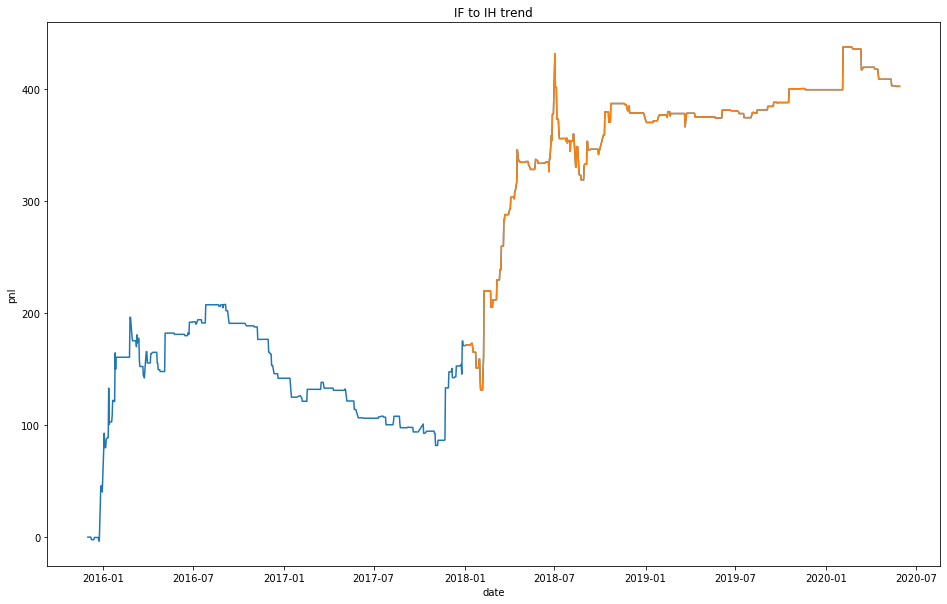

In [91]:
train_stat =result["trend.signal.stat"]["train.stat"]
good_strat = (train_stat["final.result"]["avg.pnl"]>2) & (train_stat["final.result"]["num"]>20)
train_pnl = train_stat["daily.pnl"].loc[:, good_strat].sum(axis=1)/sum(good_strat)
test_stat =result["trend.signal.stat"]["test.stat"]
test_pnl = test_stat["daily.pnl"].loc[:, good_strat].sum(axis=1)/sum(good_strat)
pnl = np.append(train_pnl, test_pnl)
plt.figure(1, figsize=(16, 10));
plt.title("");
plt.xlabel("date");
plt.ylabel("pnl");
plt.title(product_x+" to "+product_y+" trend");
plt.plot(format_dates, pnl.cumsum());
plt.plot(format_dates[test_sample], pnl.cumsum()[test_sample])
print(sharpe(train_pnl), sharpe(test_pnl))
## 0.8343249196536064 1.0795484808462001



- we can see that strategies in training set can still perform well in test set

In [127]:
from collections import OrderedDict
def get_arb_signal_pnl(file, product_x, product_y, signal_name, thre_mat, reverse=1, tranct=1.1e-4, max_spread_x=1.1,
                       max_spread_y=1.1,tranct_ratio=True, HEAD_PATH="d:/intern", SAVE_PATH="e:/intern", rebate=0):
    ## load data
    data_x = load(HEAD_PATH+"/pkl tick/"+product_x+"/"+file)
    data_y = load(HEAD_PATH+"/pkl tick/"+product_y+"/"+file)
    [time_x, time_y] = load(HEAD_PATH+"/comb time/"+product_x+"_"+product_y+"/"+file)
    S_x = load(SAVE_PATH+"/tmp pkl/"+product_x+"/"+signal_name+"/"+file)
    S_y = load(SAVE_PATH+"/tmp pkl/"+product_y+"/"+signal_name+"/"+file)
    S = S_x[time_x] - S_y[time_y]    ## calculate the difference of signals               
    pred = S*reverse
    data_y = data_y[time_y].reset_index(drop=True)
    data_x = data_x[time_x].reset_index(drop=True)
    good_x = data_x["good"]
    good_y = data_y["good"]
    pred = pred[good_x & good_y]
    data_x = data_x[good_x & good_y].reset_index(drop=True)    
    data_y = data_y[good_x & good_y].reset_index(drop=True)
    result = pd.DataFrame(data=OrderedDict([("open", thre_mat["open"].values), ("close", thre_mat["close"].values),
                               ("num", 0), ("avg.pnl", 0), ("pnl", 0), ("avg.ret", 0), ("ret", 0)]), 
                          index=thre_mat.index)
    count = 0;
    cur_spread_x = data_x["ask"]-data_x["bid"]
    cur_spread_y = data_y["ask"]-data_y["bid"]
    for thre in thre_mat.iterrows():
        count = count+1
        buy = pred>thre[1]["open"]
        sell = pred<-thre[1]["open"]
        signal = pd.Series(data=0, index=data_x.index)
        position = signal.copy()
        signal[buy] = 1
        signal[sell] = -1
        scratch = -thre[1]["close"]
        position_pos = pd.Series(data=np.nan, index=data_x.index)
        position_pos.iloc[0] = 0
        position_pos[(signal==1) & (data_x["next.ask"]>0) & (data_x["next.bid"]>0) & (cur_spread_x<max_spread_x) &
                    (data_y["next.ask"]>0) & (data_y["next.bid"]>0) & (cur_spread_y<max_spread_y)] = 1
        position_pos[(pred< -scratch) & (data_x["next.bid"]>0) & (data_y["next.ask"]>0) & (cur_spread_x<max_spread_x) &
                    (cur_spread_y<max_spread_y)] = 0
        position_pos.ffill(inplace=True)
        pre_pos = position_pos.shift(1)
        notional_position_pos_x = pd.Series(data=0, index=data_x.index)
        notional_position_pos_y = pd.Series(data=0, index=data_y.index)
        notional_position_pos_y[position_pos==1] = 1
        notional_position_pos_y[(position_pos==1) & (pre_pos==1)] = np.nan
        notional_position_pos_x[(notional_position_pos_x==1)] = 1/data_x["next.ask"][(notional_position_pos_x==1)]
        notional_position_pos_y[(notional_position_pos_y==1)] = -1/data_y["next.bid"][(notional_position_pos_y==1)]
        notional_position_pos_x.ffill(inplace=True)
        notional_position_pos_y.ffill(inplace=True)
        position_neg = pd.Series(data=np.nan, index=data_x.index)
        position_neg.iloc[0] = 0
        position_neg[(signal==-1) & (data_x["next.ask"]>0) & (data_x["next.bid"]>0) & (cur_spread_x<max_spread_x) &
                    (data_y["next.ask"]>0) & (data_y["next.bid"]>0) & (cur_spread_y<max_spread_y)] = -1
        position_neg[(pred> scratch) & (data_x["next.ask"]>0) & (data_y["next.bid"]>0) & (cur_spread_y<max_spread_y)] = 0
        position_neg.ffill(inplace=True)
        pre_neg = position_neg.shift(1)
        notional_position_neg_x = pd.Series(data=0, index=data_x.index)
        notional_position_neg_y = pd.Series(data=0, index=data_y.index)
        notional_position_neg_y[position_neg==-1] = -1
        notional_position_neg_y[(position_neg==-1) & (pre_neg==-1)] = np.nan
        notional_position_neg_x[(notional_position_neg_x==-1)] = -1/data_x["next.bid"][(notional_position_neg_x==-1)]
        notional_position_neg_y[(notional_position_neg_y==-1)] = 1/data_y["next.ask"][(notional_position_neg_y==-1)]
        notional_position_neg_x.ffill(inplace=True)
        notional_position_neg_y.ffill(inplace=True)
        position = position_pos + position_neg
        notional_position_x = notional_position_pos_x+notional_position_neg_x
        notional_position_y = notional_position_pos_y+notional_position_neg_y
        #position[n_bar-1] = 0
        position.iloc[0] = 0
        position.iloc[-10:] = 0
        notional_position_x.iloc[0] = 0
        notional_position_y.iloc[0] = 0
        notional_position_x.iloc[-10:] = 0
        notional_position_y.iloc[-10:] = 0
        notional_change_pos_x = notional_position_x-notional_position_x.shift(1)
        notional_change_pos_y = notional_position_y-notional_position_y.shift(1)
        change_pos = position - position.shift(1)
        change_pos.iloc[0] = 0
        change_base = pd.Series(data=0, index=data_x.index)
        notional_change_pos_x.iloc[0] = 0
        notional_change_pos_y.iloc[0] = 0
        change_base_x = pd.Series(data=0, index=data_x.index)
        change_base_y = pd.Series(data=0, index=data_y.index)
        
        change_buy = change_pos>0
        change_sell = change_pos<0
        if (tranct_ratio):
            change_base[change_buy] = data_x["next.ask"][change_buy]*(1+tranct)-data_y["next.bid"][change_buy]*(1-tranct)
            change_base[change_sell] = data_x["next.bid"][change_sell]*(1-tranct)-data_y["next.ask"][change_sell]*(1+tranct)
            change_base_x[change_buy] = data_x["next.ask"][change_buy]*(1+tranct)
            change_base_x[change_sell] = data_x["next.bid"][change_sell]*(1-tranct)
            change_base_y[change_buy] = data_y["next.bid"][change_buy]*(1-tranct)
            change_base_y[change_sell] = data_y["next.ask"][change_sell]*(1+tranct)
        else:
            change_base[change_buy] = data_x["next.ask"][change_buy]+tranct-(data_y["next.bid"][change_buy]-tranct)
            change_base[change_sell] = data_x["next.bid"][change_sell]-tranct-(data_y["next.ask"][change_sell]+tranct)
            change_base_x[change_buy] = data_x["next.ask"][change_buy]+tranct
            change_base_x[change_sell] = data_x["next.bid"][change_sell]-tranct
            change_base_y[change_buy] = data_y["next.bid"][change_buy]-tranct
            change_base_y[change_sell] = data_y["next.ask"][change_sell]+tranct
        final_pnl = -sum(change_base*change_pos)
        ret = -sum(change_base_x*notional_change_pos_x)-sum(change_base_y*notional_change_pos_y)
        num = sum((position!=0) & (change_pos!=0))
        if num == 0:
            result.loc[thre[0], ("num", "avg.pnl", "pnl", "avg.ret", "ret")] = (0,0,0,0,0)
            return result
        else:
            avg_pnl = np.divide(final_pnl, num)
            avg_ret = np.divide(ret,num)
            result.loc[thre[0], ("num", "avg.pnl", "pnl", "avg.ret", "ret")] = (num, avg_pnl, final_pnl, avg_ret,ret)
    return result


In [152]:
signal_name = "total.trade.imb.comb" 
product_x = "IF"
product_y = "IH"
all_signal = load(SAVE_PATH+"/all signal/"+product_x+"_"+product_y+"."+signal_name+".pkl")
thre_list = []
open_list = np.arange(0.1,0.3,0.01)
for cartesian in itertools.product(open_list, np.array([0.2, 0.4, 0.6, 0.8, 1.0])):
        thre_list.append((cartesian[0], -cartesian[0] * cartesian[1]))
thre_list = np.array(thre_list)
thre_mat = pd.DataFrame(data=OrderedDict([("open", thre_list[:, 0]), ("close", thre_list[:, 1])]))

In [154]:
%%time
train_result = parLapply(CORE_NUM, all_dates[train_sample], get_arb_signal_pnl, product_x=product_x, product_y=product_y, signal_name="total.trade.imb.comb",
                  thre_mat=thre_mat, reverse=1, tranct=0.25e-4, max_spread_x=0.61, max_spread_y=0.61,tranct_ratio=True)
test_result = parLapply(CORE_NUM, all_dates[test_sample], get_arb_signal_pnl, product_x=product_x, product_y=product_y, signal_name="total.trade.imb.comb",
                  thre_mat=thre_mat, reverse=1, tranct=0.25e-4, max_spread_x=0.61, max_spread_y=0.61,tranct_ratio=True)
# Wall time: 4min 35s

Wall time: 4min 35s


In [155]:
train_stat = get_hft_summary(train_result, thre_mat,sum(train_sample))
good_strat = (train_stat["final.result"]["avg.pnl"]>0) & (train_stat["final.result"]["num"]>0)
sum(good_strat)

0

In [156]:
train_stat["final.result"]

,open,close,num,avg.pnl,total.pnl,sharpe,drawdown,max.drawdown,avg.ret,total.ret,sharpe.ret,drawdown.ret,max.drawdown.ret,mar,mar.ret
0,0.10,-0.020,559,-1.462445,-817.507015,-1.247239,1014.856180,1033.269215,-0.000722,-0.403731,-1.809576,0.417832,0.417832,-0.791185,-0.966253
1,0.10,-0.040,538,-1.627700,-875.702680,-1.362540,1087.048775,1109.374205,-0.000795,-0.427909,-1.955215,0.436886,0.436886,-0.789366,-0.979452
2,0.10,-0.060,521,-1.715216,-893.627345,-1.377561,1114.175470,1119.404865,-0.000830,-0.432669,-1.973891,0.442357,0.442357,-0.798306,-0.978100
3,0.10,-0.080,512,-1.720078,-880.679825,-1.321085,1093.828575,1094.161315,-0.000826,-0.423110,-1.896257,0.424189,0.424189,-0.804890,-0.997454
4,0.10,-0.100,510,-1.763271,-899.268415,-1.338247,1117.015320,1117.015320,-0.000839,-0.427919,-1.908257,0.433109,0.433109,-0.805064,-0.988017
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.29,-0.058,5,-1.199291,-5.996455,-0.422311,11.840665,11.840665,-0.000435,-0.002175,-0.719022,0.003022,0.003022,-0.506429,-0.719847
96,0.29,-0.116,5,-1.159286,-5.796430,-0.411716,11.640640,11.640640,-0.000434,-0.002169,-0.717889,0.003015,0.003015,-0.497948,-0.719252
97,0.29,-0.174,5,-1.159286,-5.796430,-0.411716,11.640640,11.640640,-0.000434,-0.002169,-0.717889,0.003015,0.003015,-0.497948,-0.719252
98,0.29,-0.232,5,-1.159286,-5.796430,-0.411716,11.640640,11.640640,-0.000434,-0.002169,-0.717889,0.003015,0.003015,-0.497948,-0.719252


- we can see that there are no good strategies for a-m arbitrage
- the reason may be that oil contracts have too low volatility and intraday trading cannot cover transaction cost


In [157]:
test_stat = get_hft_summary(test_result, thre_mat,sum(test_sample))

In [159]:
test_stat["final.result"]

,open,close,num,avg.pnl,total.pnl,sharpe,drawdown,max.drawdown,avg.ret,total.ret,sharpe.ret,drawdown.ret,max.drawdown.ret,mar,mar.ret
0,0.10,-0.020,340,-1.015418,-345.242190,-1.406897,371.238510,381.109245,-0.000487,-0.165419,-3.024417,0.173143,0.176621,-0.905888,-0.936579
1,0.10,-0.040,329,-1.240628,-408.166465,-1.521822,451.232065,462.520010,-0.000537,-0.176524,-3.034777,0.187663,0.191573,-0.882484,-0.921449
2,0.10,-0.060,325,-1.053687,-342.448255,-1.192728,393.024210,441.966780,-0.000509,-0.165412,-2.627247,0.183691,0.187078,-0.774828,-0.884187
3,0.10,-0.080,322,-1.239696,-399.182060,-1.358032,434.926715,497.270840,-0.000559,-0.180036,-2.938854,0.190722,0.193801,-0.802746,-0.928975
4,0.10,-0.100,319,-1.219942,-389.161645,-1.285462,425.506135,495.326370,-0.000572,-0.182334,-2.865540,0.192875,0.197058,-0.785667,-0.925282
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.29,-0.058,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN
96,0.29,-0.116,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN
97,0.29,-0.174,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN
98,0.29,-0.232,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN
